In [1]:
import pandas as pd
import numpy as np

# --- Experiment Configuration ---
DATA_PATH = "data/assist2009/assist2009_split.csv"

MIN_INTERACTIONS = 10     # Students must have at least this many interactions with the target
PURITY_THRESHOLD = 0.90   # Teacher must be 90% dedicated to the target skill
STUDENT_PURITY = 0.90     # Student history must be 90% composed of this target skill
TEACHER_PURITY = 0.8     # Teacher must be 90% dedicated to one skill

print(f"Loading {DATA_PATH}...")
df = pd.read_csv(DATA_PATH, encoding='ISO-8859-1', low_memory=False)

df_train = df[df['split'].isin(['train_gnn', 'train_rnn'])].copy()
print(f"Loaded {len(df_train)} interactions from the Training Split.")

Loading data/assist2009/assist2009_split.csv...
Loaded 354252 interactions from the Training Split.


In [2]:
# 1. Count total interactions per teacher
teacher_counts = df_train.groupby('teacher_id').size()

# 2. Filter out noisy teachers (< 50 interactions total)
active_teachers = teacher_counts[teacher_counts > 10].index
df_active = df_train[df_train['teacher_id'].isin(active_teachers)]

# 3. Calculate "Skill Purity"
# Count (Teacher, Skill) pairs
teacher_skill_counts = df_active.groupby(['teacher_id', 'skill_id']).size().reset_index(name='count')
totals = df_active.groupby('teacher_id').size().reset_index(name='total')

stats = pd.merge(teacher_skill_counts, totals, on='teacher_id')
stats['purity'] = stats['count'] / stats['total']

# 4. Keep teachers who meet the threshold
specialists = stats[stats['purity'] >= TEACHER_PURITY].copy()

print(f"Found {len(specialists)} specialist teachers.")
print("\n--- Specialist Teacher IDs ---")
print(specialists['teacher_id'].unique())

Found 16 specialist teachers.

--- Specialist Teacher IDs ---
[46148 47508 50218 52662 53676 57045 57047 57051 57468 59442 60021 62286
 63066 63103 63339 65538]


In [3]:
# Group by skill to count unique specialist teachers
skill_popularity = specialists.groupby('skill_id')['teacher_id'].nunique()

# Filter for skills with MORE THAN 3 teachers
valid_skills = skill_popularity[skill_popularity >= 3].sort_values(ascending=False)

print(f"Found {len(valid_skills)} skills with >3 specialist teachers.")
print("\n--- Valid Skill IDs (sorted by teacher count) ---")
print(valid_skills)

Found 3 skills with >3 specialist teachers.

--- Valid Skill IDs (sorted by teacher count) ---
skill_id
311.0    5
18.0     3
280.0    3
Name: teacher_id, dtype: int64


In [4]:
# Filter the main specialists dataframe to only include our 'Valid Skills'
valid_specialists = specialists[specialists['skill_id'].isin(valid_skills.index)]

print(f"Subset of teachers teaching valid skills: {len(valid_specialists)}")
print("\n--- Valid Teachers and their Skills ---")
# Show the mapping
display(valid_specialists[['teacher_id', 'skill_id', 'purity', 'total']].sort_values('skill_id'))

Subset of teachers teaching valid skills: 11

--- Valid Teachers and their Skills ---


,teacher_id,skill_id,purity,total
1216,60021,18.0,1.0,49
1314,63103,18.0,1.0,24
1320,63339,18.0,1.0,629
824,52662,280.0,1.0,13
1050,57045,280.0,1.0,972
1052,57051,280.0,1.0,817
815,50218,311.0,1.0,316
619,47508,311.0,1.0,48
1128,59442,311.0,1.0,316
574,46148,311.0,1.0,21


In [5]:
print("--- Final Summary: Teachers per Valid Skill ---")

# Aggregate to get the list of IDs
summary = valid_specialists.groupby('skill_id').agg(
    teacher_count=('teacher_id', 'nunique'),
    teacher_ids=('teacher_id', list)
).sort_values('teacher_count', ascending=False)

# Display full width so lists aren't truncated
pd.set_option('display.max_colwidth', None)
display(summary)

--- Final Summary: Teachers per Valid Skill ---


,teacher_count,teacher_ids
skill_id,,
311.0,5,"[46148, 47508, 50218, 59442, 62286]"
18.0,3,"[60021, 63103, 63339]"
280.0,3,"[52662, 57045, 57051]"


In [6]:
import torch
import pandas as pd
import numpy as np
import os

# Import your custom modules
# Make sure these files are in the same folder as your notebook
from hybrid_data_manager import HybridDataManager
from hybrid_model import LinkPredGNN, HybridRNN, EndToEndHybrid

def load_inference_system(dataset_name, model_path, data_dir="data"):
    """
    Reconstructs the Data Manager and Model, then loads the trained weights.
    """
    print(f"--- Loading System for {dataset_name} ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Load Data & Recreate Manager
    # CRITICAL: We must use the exact same split file and settings as training
    if "assist2009" in dataset_name:
        csv_path = os.path.join(data_dir, "assist2009", "assist2009_split.csv")
    elif "assist2012" in dataset_name:
        csv_path = os.path.join(data_dir, "assist2012", "assist2012_split.csv")

    print(f"Reading data from {csv_path}...")
    df = pd.read_csv(csv_path, low_memory=False)

    # Initialize Manager (Must match training params: seq_len=200, use_metadata=True)
    manager = HybridDataManager(
        df,
        fractions=(0.6, 0.2, 0.1, 0.1),
        seq_len=200,
        use_metadata=True
    )
    manager.to(device)

    # 2. Recreate Model Architecture
    # Ensure hidden dims match what you trained with (default 64)
    gnn_model = LinkPredGNN(
        manager.graph,
        hidden=64,
        edge_hidden=6, # Dimension of edge features (e.g. correctness)
        num_layers=2,
        dropout=0.4,
        norm=True
    )
    rnn_model = HybridRNN(
            gnn_hidden_dim=gnn_model.hidden,
            rnn_hidden_dim=64,
            num_layers=2,
            dropout=0.5,
        ).to(device)
    model = EndToEndHybrid(gnn_model, rnn_model).to(device)

    # 3. Load Weights
    print(f"Loading weights from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval() # Set to inference mode

    return model, manager, device

def get_student_embedding(student_id, model, manager, device):
    """
    Returns the FINAL hidden state of the student after their 'train_rnn' history.
    """
    # 1. Check if student exists
    if student_id not in manager.student_map:
        print(f"Error: Student ID {student_id} not found in map.")
        return None

    # 2. Extract specific history: 'train_rnn' split only
    # (This aligns with "up to rnn_train")
    df_student = manager.raw_df[
        (manager.raw_df['user_id'] == student_id) &
        (manager.raw_df['split'] == 'train_rnn')
    ].copy()

    if df_student.empty:
        print(f"Warning: Student {student_id} has no data in 'train_rnn' split.")
        return None

    # 3. Convert to Tensor Sequence
    # We use the manager's internal method to ensure consistent padding/mapping
    seq_dict = manager._extract_sequences(df_student, seq_len=manager.seq_len)

    # Move to GPU
    seq_dict = {k: v.to(device) for k, v in seq_dict.items()}

    # 4. Forward Pass
    with torch.no_grad():
        # Get Context from GNN
        gnn_out = model.gnn(manager.graph)

        # Run RNN
        # rnn_out shape: [Batch=1, Seq_Len=200, Hidden_Dim=64]
        rnn_out = model.get_embeddings(manager.graph, seq_dict)

        # 5. Extract Last Valid State
        # The sequence is padded with 0s at the END.
        # We use the mask to find the index of the last real interaction.
        mask = seq_dict['mask'][0] # Shape [200]
        valid_len = mask.sum().item()

        if valid_len == 0:
            return torch.zeros(64).cpu().numpy()

        # Index is length - 1 (e.g., length 1 -> index 0)
        last_idx = valid_len - 1
        final_vector = rnn_out[0, last_idx, :]

        return final_vector.cpu().numpy()

In [7]:
# --- CONFIGURATION ---
DATASET_NAME = "assist2009"
# Point this to your saved .pth file
MODEL_PATH = "log/H2GKT_assist2009_seed42_best_model.pth"

# Load System
model, manager, device = load_inference_system(DATASET_NAME, MODEL_PATH)
print("System loaded and ready for inference.")

--- Loading System for assist2009 ---
Reading data from data/assist2009/assist2009_split.csv...
Stats: 4151 Students, 16891 Problems, 245 Classes, 149 Teachers
Using pre-computed 'split' column for data partitioning.
RNN Training View: 3678 students.
Validation RNN View: 3096 students.
Test RNN View (Full Context): 4151 students.
Loading weights from log/H2GKT_assist2009_seed42_best_model.pth...
System loaded and ready for inference.


In [8]:
# Pick a target student ID
# (For testing, let's pick the first available student in the map)
test_student_id = list(manager.student_map.keys())[0]
print(f"Testing with Student ID: {test_student_id}")

# Extract
vector = get_student_embedding(test_student_id, model, manager, device)

if vector is not None:
    print(f"\n✅ Successfully extracted embedding!")
    print(f"Shape: {vector.shape}")
    print(f"First 10 values:\n{vector[:10]}")
else:
    print("❌ Failed to extract embedding.")

Testing with Student ID: 14

✅ Successfully extracted embedding!
Shape: (64,)
First 10 values:
[ 0.413415   -0.01253213  0.36056054  0.27065942  0.19907247 -0.25796977
 -0.16995154 -0.31347877  0.32161713 -0.10941823]


In [9]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# --- 1. CONFIGURATION ---
TARGET_SKILL_ID = 280.0
MIN_INTERACTIONS = 10
PURITY_THRESHOLD = 0.8  # Using the relaxed threshold you mentioned earlier

print(f"Re-identifying cohort for Skill {TARGET_SKILL_ID}...")

# --- 2. RE-CREATE THE COHORT (Using Loaded Data) ---
# We use manager.raw_df because it's guaranteed to be loaded
df_data = manager.raw_df[manager.raw_df['split'].isin(['train_gnn', 'train_rnn'])].copy()

# A. Find students interacting with this skill
target_interactions = df_data[df_data['skill_id'] == TARGET_SKILL_ID]
student_counts = target_interactions.groupby('user_id').size()

# B. Filter 1: Enough Interactions
candidates = student_counts[student_counts >= MIN_INTERACTIONS].index

# C. Filter 2: Purity
# (Check if these students mostly do this skill)
valid_students = []
for student in candidates:
    # Get total history for this student
    total_history = df_data[df_data['user_id'] == student]
    total_count = len(total_history)

    # Get target history
    target_count = len(total_history[total_history['skill_id'] == TARGET_SKILL_ID])

    if (target_count / total_count) >= PURITY_THRESHOLD:
        valid_students.append(student)

print(f"Found {len(valid_students)} valid students matching constraints.")

# --- 3. EXTRACTION FUNCTION ---
def build_tsne_dataset(student_list, model, manager, device):
    data_points = []

    # Pre-filter for efficiency
    df_skill_subset = df_data[df_data['skill_id'] == TARGET_SKILL_ID]

    print(f"Extracting vectors for {len(student_list)} students...")

    for student_id in tqdm(student_list):
        # A. Determine Main Teacher (Label)
        student_interactions = df_skill_subset[df_skill_subset['user_id'] == student_id]
        if student_interactions.empty:
            continue

        # Mode returns the most frequent teacher
        main_teacher = student_interactions['teacher_id'].mode()[0]

        # B. Extract Embedding
        vector = get_student_embedding(student_id, model, manager, device)

        if vector is not None:
            data_points.append({
                "student_id": student_id,
                "teacher_id": int(main_teacher),
                "vector": vector
            })

    return pd.DataFrame(data_points)

# --- 4. EXECUTE ---
if len(valid_students) > 0:
    df_plot = build_tsne_dataset(valid_students, model, manager, device)

    print("\n✅ Extraction Complete!")
    print("Distribution of students per teacher:")
    print(df_plot['teacher_id'].value_counts())

    # Show first few rows
    display(df_plot.head())
else:
    print("❌ No students found. Check constraints.")

Re-identifying cohort for Skill 280.0...
Found 75 valid students matching constraints.
Extracting vectors for 75 students...


  0%|          | 0/75 [00:00<?, ?it/s]


✅ Extraction Complete!
Distribution of students per teacher:
teacher_id
57045    38
57051    36
52662     1
Name: count, dtype: int64


,student_id,teacher_id,vector
0,81237,52662,"[-0.20069693, -0.009812881, -0.14066845, -0.22428167, 0.16251989, 0.044860654, 0.03865398, 0.18795177, -0.15196785, -0.035877895, 0.20432355, 0.12343946, -0.17036866, -0.018140145, -0.15126976, -0.3345387, 0.20862754, 0.052918725, -0.21316133, 0.027868424, 0.03103414, -0.08811067, -0.25531158, 0.004068586, -0.0040873485, -0.010926456, -0.041203905, 0.073047295, 0.18442477, -0.15747991, -0.019292776, 0.040684257, -0.058546033, -0.09237044, -0.095112465, -0.105693996, -0.21698579, 0.20040853, 0.1401223, 0.05491888, 0.13750957, 0.043698836, -0.023215134, 0.024968587, -0.07444372, 0.045873225, 0.09122236, 0.20818521, 0.20395209, 0.05572935, -0.1922428, 0.20395324, -0.15889683, -0.19076791, 0.07796035, 0.047990333, -0.15429753, -0.06679456, 0.16249925, 0.21588969, -0.18347114, 0.24242164, 0.0012488324, 0.1657953]"
1,86676,57051,"[-0.6774206, -0.20798051, -0.03169125, -0.045223784, 0.4484217, 0.17047423, -0.22269814, 0.59441614, -0.38039473, -0.04193296, 0.4128519, 0.31571606, -0.59263325, 0.11504404, -0.2312325, -0.16174817, 0.37874764, 0.38245288, -0.40957284, 0.05760945, -0.36877197, -0.35279748, -0.6937714, -0.0071878172, 0.34132323, 0.17000501, -0.3856603, 0.058660828, 0.44495407, -0.048021965, 0.025597673, -0.05093656, -0.024593847, -0.360638, -0.062112506, -0.26218134, -0.63486236, 0.61873734, 0.30063272, 0.3720037, 0.3874864, -0.06044067, -0.41615513, 0.22070959, -0.24259768, 0.013261769, 0.07957255, 0.06670737, 0.6739884, -0.0034971768, -0.3613807, 0.42928016, -0.47772226, -0.43008482, 0.13269877, 0.059253577, -0.26645923, 0.107973695, 0.46519914, 0.41977194, -0.45291972, 0.19035628, 0.2993712, 0.34243077]"
2,86681,57051,"[-0.6557624, -0.20746891, 0.029396538, -0.06321971, 0.45005587, 0.1933941, -0.19724126, 0.5858842, -0.39445385, -0.041049015, 0.42757538, 0.32073715, -0.5988302, 0.12641743, -0.2909625, -0.3447498, 0.36859018, 0.4011957, -0.4333968, 0.05736481, -0.3996539, -0.32723802, -0.69813424, -0.005639544, 0.33235773, 0.17904976, -0.4127056, 0.06685656, 0.43351802, -0.06358411, 0.017017255, -0.028506368, -0.02452434, -0.3798626, -0.060886934, -0.25001076, -0.6480946, 0.6237391, 0.3082708, 0.37648216, 0.36485377, 0.010056986, -0.44214204, 0.23916914, -0.24367052, 0.0023163918, 0.07791308, 0.16081502, 0.6671635, -0.0029358598, -0.3500734, 0.42654032, -0.46179983, -0.45445198, 0.13114198, 0.08738977, -0.24966997, 0.11453686, 0.46544036, 0.4228552, -0.47136927, 0.21933594, 0.2948228, 0.3261445]"
3,86690,57051,"[-0.38132566, -0.043704536, -0.16448568, -0.05163963, 0.2795726, -0.045718428, -0.07901584, 0.22720692, -0.07468854, -0.028503632, 0.23656413, 0.1989312, -0.24732363, 0.029095236, 0.052070726, -0.0512333, 0.32772708, 0.07511266, -0.2141699, 0.044811364, -0.091163166, -0.22564285, -0.18791352, -0.017078014, 0.09800661, -0.027753582, -0.12736015, 0.05296829, 0.2660087, -0.04161152, 0.06192434, -0.12254384, -0.10089243, -0.028194336, -0.09012324, -0.13572225, -0.20923994, 0.31906998, 0.17160323, 0.073372655, 0.25137174, -0.16170278, 0.01544098, -0.0032726536, -0.10062419, 0.103231415, 0.120695196, 0.026208693, 0.27796334, 0.0029001078, -0.20595524, 0.22170344, -0.28529012, -0.05368081, 0.03558835, -0.06443719, -0.06339069, -0.05012313, 0.2804311, 0.18357545, -0.18282886, 0.19499514, 0.07677843, 0.24949667]"
4,86691,57051,"[-0.63113844, -0.19874117, 0.16428654, -0.10944382, 0.4549903, 0.2234621, -0.12543689, 0.58431107, -0.4103736, 0.005788253, 0.460917, 0.3306315, -0.61748797, 0.20449908, -0.36033896, -0.56440014, 0.35664168, 0.455931, -0.48286664, 0.053159367, -0.56756, -0.25270227, -0.71367306, -0.019026766, 0.29700193, 0.1794581, -0.52345425, 0.08634888, 0.42127302, -0.0975367, -0.035748307, 0.0014443547, -0.024710014, -0.40967086, -0.060101535, -0.19143783, -0.67089564, 0.6438231, 0.33045432, 0.36470428, 0.31412414, 0.11626427, -0.45232564, 0.27620366, -0.24058, -0.043858882, 0.075333245, 0.30351642, 0.6628904, -0.010507578, -0.3550972, 0.4231829, -0.38304463, -0.489377

Running t-SNE on 75 vectors...


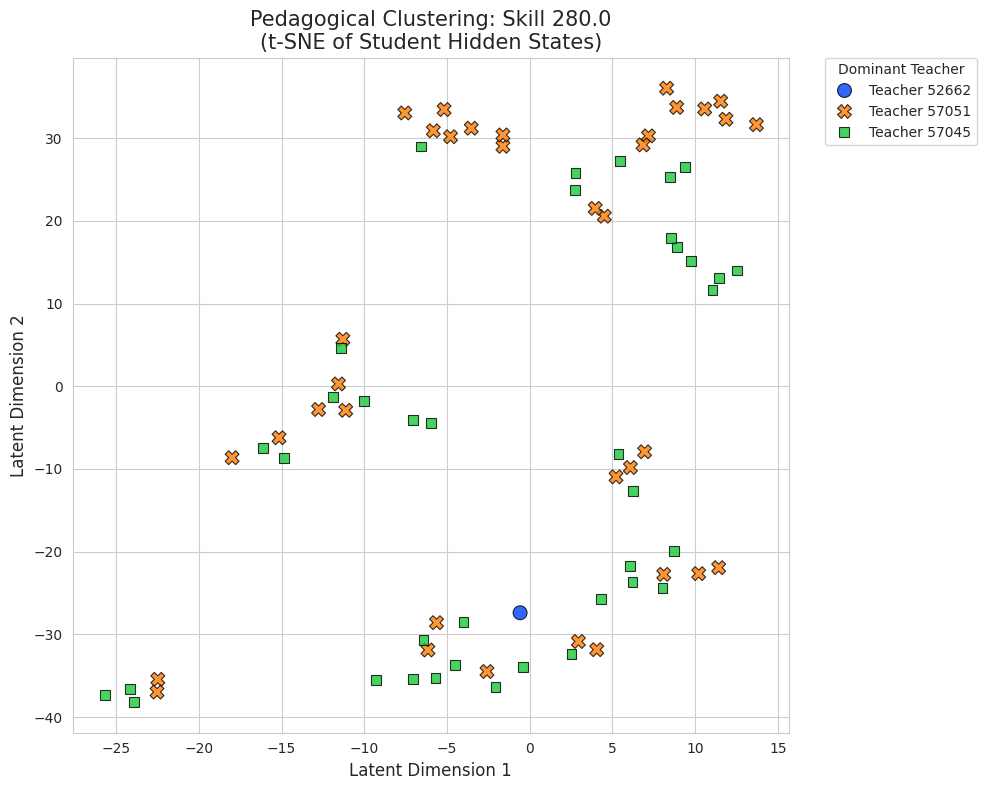

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# --- CONFIGURATION ---
PERPLEXITY = 5  # Standard value. If error occurs (n_samples too small), try 5 or 10.
RANDOM_STATE = 42

print(f"Running t-SNE on {len(df_plot)} vectors...")

# 1. Prepare Data Matrix
# Stack the list of arrays into a single 2D matrix (N_students x 64_dim)
X = np.stack(df_plot['vector'].values)

# 2. Run t-SNE
# Ensure perplexity isn't larger than the dataset
n_samples = X.shape[0]
eff_perplexity = min(PERPLEXITY, n_samples - 1)

tsne = TSNE(n_components=2, perplexity=eff_perplexity, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X)

# 3. Add coordinates to DataFrame
df_plot['x'] = X_embedded[:, 0]
df_plot['y'] = X_embedded[:, 1]
# Convert Teacher ID to string so the plot treats it as a Category (distinct colors), not a Number (gradient)
df_plot['Teacher Label'] = "Teacher " + df_plot['teacher_id'].astype(str)

# 4. Plot
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Create Scatter Plot
sns.scatterplot(
    data=df_plot,
    x='x', y='y',
    hue='Teacher Label',    # Color by Teacher
    style='Teacher Label',  # Different shapes for accessibility
    palette='bright',       # High contrast colors
    s=100,                  # Dot size
    alpha=0.8,              # Slight transparency
    edgecolor='black'       # Outline for clarity
)

# 5. Aesthetics
plt.title(f"Pedagogical Clustering: Skill {TARGET_SKILL_ID}\n(t-SNE of Student Hidden States)", fontsize=15)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.legend(title="Dominant Teacher", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [13]:
print(df.dtypes)

order_id                  int64
assignment_id             int64
user_id                   int64
assistment_id             int64
problem_id                int64
original                  int64
correct                   int64
attempt_count             int64
ms_first_response         int64
tutor_mode               object
answer_type              object
sequence_id               int64
student_class_id          int64
position                  int64
type                     object
base_sequence_id          int64
skill_id                float64
skill_name               object
teacher_id                int64
school_id                 int64
hint_count                int64
hint_total                int64
overlap_time              int64
template_id               int64
answer_id               float64
answer_text              object
first_action              int64
bottom_hint             float64
opportunity               int64
opportunity_original    float64
split                    object
dtype: o